In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# CIFAR-10 dataset
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

 

 

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
 

100%|██████████| 170498071/170498071 [00:02<00:00, 71439120.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:

# Modified ResNet-18

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

 

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [4]:
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=8)
        self.Dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(256, num_classes)
 

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
 

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = self.Dropout(out)
        out = out.view(out.size(0), -1)
        h = x.view(x.shape[0], -1)
        out = self.linear(out)
        return out

In [5]:
# Model
model = ModifiedResNet(BasicBlock, [2, 2, 2, 1]).to(device)
 
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,  momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [6]:
print("Number of Trainable parameter:", sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of Trainable parameter: 4024394


In [7]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [8]:
num_epochs = 60
train_accuracy = []
train_loss = []
best_train_loss=0

for epoch in range(num_epochs):
    # Training loop
    epoch_acc = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
        acc = calculate_accuracy(output, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_acc += acc.item()
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_acc / len(train_loader)}')
    train_accuracy.append(epoch_acc / len(train_loader))
    train_loss.append(loss.item())
    if loss < best_train_loss:
        best_train_loss = loss
        torch.save(model.state_dict(), 'best_model.pt')

    #Test
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Print the accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

Epoch [1/60], Loss: 1.3236, Accuracy: 0.42320457453614846
Test Accuracy of the model on the 10000 test images: 52.95%
Epoch [2/60], Loss: 1.0514, Accuracy: 0.5330294305822136
Test Accuracy of the model on the 10000 test images: 63.61%
Epoch [3/60], Loss: 0.7603, Accuracy: 0.6233005438259757
Test Accuracy of the model on the 10000 test images: 67.32%
Epoch [4/60], Loss: 0.5732, Accuracy: 0.6721849008317339
Test Accuracy of the model on the 10000 test images: 69.51%
Epoch [5/60], Loss: 0.7256, Accuracy: 0.7119921625079975
Test Accuracy of the model on the 10000 test images: 72.58%
Epoch [6/60], Loss: 0.6788, Accuracy: 0.7347048944337812
Test Accuracy of the model on the 10000 test images: 77.16%
Epoch [7/60], Loss: 0.4528, Accuracy: 0.7656349968010236
Test Accuracy of the model on the 10000 test images: 78.14%
Epoch [8/60], Loss: 0.7327, Accuracy: 0.7792506397952655
Test Accuracy of the model on the 10000 test images: 80.49%
Epoch [9/60], Loss: 0.7791, Accuracy: 0.796325175943698
Test Ac

In [14]:
print("Number of Trainable parameter:", sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of Trainable parameter: 4024394


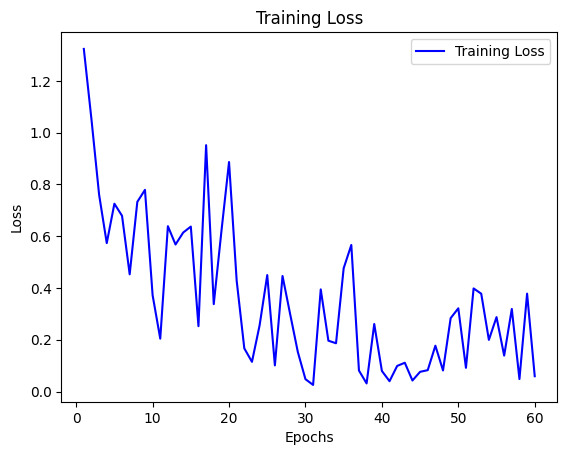

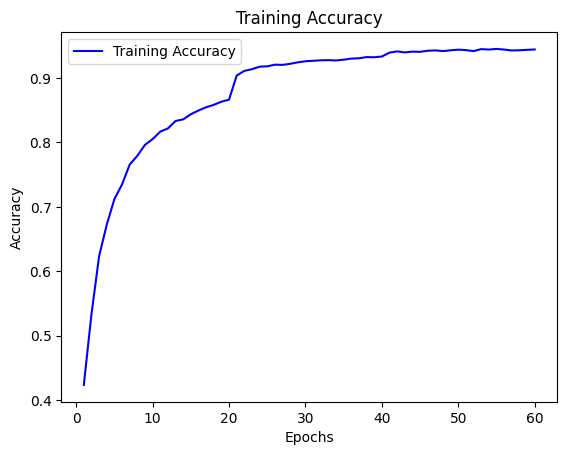

In [15]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_accuracy) + 1)

# Plot train loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot train accuracy
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()